In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

import argparse
import os

import fsspec
import numpy as np
import pandas as pd
import xarray as xr
import goes2go
import pandas as pd
from tqdm import tqdm

from pyproj import Proj
from scipy.interpolate import make_splrep

In [100]:
ibtracs_file = 'ibtracs.ALL.list.v04r01.csv'
ibtracs_na_file = 'ibtracs.NA.list.v04r01.csv'
ibtracs_ep_file = 'ibtracs.EP.list.v04r01.csv'

In [190]:
df = pd.read_csv(ibtracs_file)
df_na = pd.read_csv(ibtracs_na_file)
df_ep = pd.read_csv(ibtracs_ep_file)

/tmp/ipykernel_1243023/1373709222.py:1: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ibtracs_file)
/tmp/ipykernel_1243023/1373709222.py:2: DtypeWarning: Columns (1,2,3,8,9,14,19,20,23,24,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_na = pd.read_csv(ibtracs_na_file)
/tmp/ipykernel_1243023/1373709222.py:2: DtypeWarning: Columns (1,2,3,8,9,14,19,20,23,24,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_na = pd.read_csv(ibtracs_na_file)
/tmp/ipykernel_1243023/1373709222.py:3: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ep = pd.read_csv(ibtracs_ep_file)
/tmp/ipykernel_1243023/1373709222.py:3: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ep = pd.read_csv(ibtracs_ep_file

### North Atlantic Files

In [191]:
df_na_filtered = df_na[df_na.SEASON.isin([2018, 2019, 2020, 2021, 2022, 2023, 2024])]
df_na_filtered = df_na_filtered[df_na_filtered.NATURE.isin(['TS', 'DS'])]
df_na_filtered = df_na_filtered[df_na_filtered.NAME != 'UNNAMED']
# filter for GOES FOV
df_na_filtered = df_na_filtered[df_na_filtered.LAT.between(-50, 50) & df_na_filtered.LON.between(-125, -25)]

# filter out storms with less than 8 points
grouped = df_na_filtered.groupby('SID')
lengths = grouped.size()
df_na_filtered = df_na_filtered[df_na_filtered.SID.isin(lengths[lengths >= 8].index)]

In [192]:
len(df_na_filtered.SID.unique())

127

In [193]:
df_na_filtered.LAT.min(), df_na_filtered.LAT.max(), df_na_filtered.LON.min(), df_na_filtered.LON.max()

(8.1, 49.8, -124.7, -25.0)

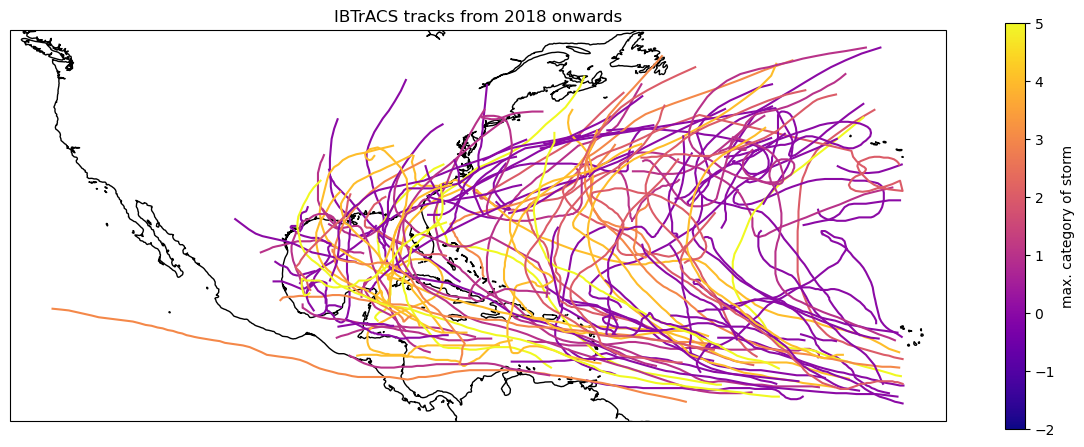

In [194]:
# Plot tracks on map
fig, ax = plt.subplots(figsize=(12, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
grouped = df_na_filtered.groupby('SID')

# plot every track with colour for category
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=-2, vmax=5)
for i, (name, group) in enumerate(grouped):
    max_cat = group['USA_SSHS'].max()
    ax.plot(group['LON'], group['LAT'], transform=ccrs.PlateCarree(), label=name, color=cmap(norm(max_cat)))

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with colorbar
plt.colorbar(sm, ax=ax, label='max. category of storm')
plt.title('IBTrACS tracks from 2018 onwards')

plt.tight_layout()

### Eastern Pacific

In [195]:
df_ep_filtered = df_ep[df_ep.SEASON.isin([2018, 2019, 2020, 2021, 2022, 2023, 2024])]
df_ep_filtered = df_ep_filtered[df_ep_filtered.NATURE.isin(['TS', 'DS'])]
df_ep_filtered = df_ep_filtered[df_ep_filtered.NAME != 'UNNAMED']
# filter for GOES FOV
df_ep_filtered = df_ep_filtered[df_ep_filtered.LAT.between(-50, 50) & df_ep_filtered.LON.between(-125, -25)]

# filter out storms with less than 8 points
grouped = df_ep_filtered.groupby('SID')
lengths = grouped.size()
df_ep_filtered = df_ep_filtered[df_ep_filtered.SID.isin(lengths[lengths >= 8].index)]

In [196]:
len(df_ep_filtered.SID.unique())

112

In [197]:
df_ep_filtered.LAT.min(), df_ep_filtered.LAT.max(), df_ep_filtered.LON.min(), df_ep_filtered.LON.max()

(8.2, 31.4, -125.0, -50.5)

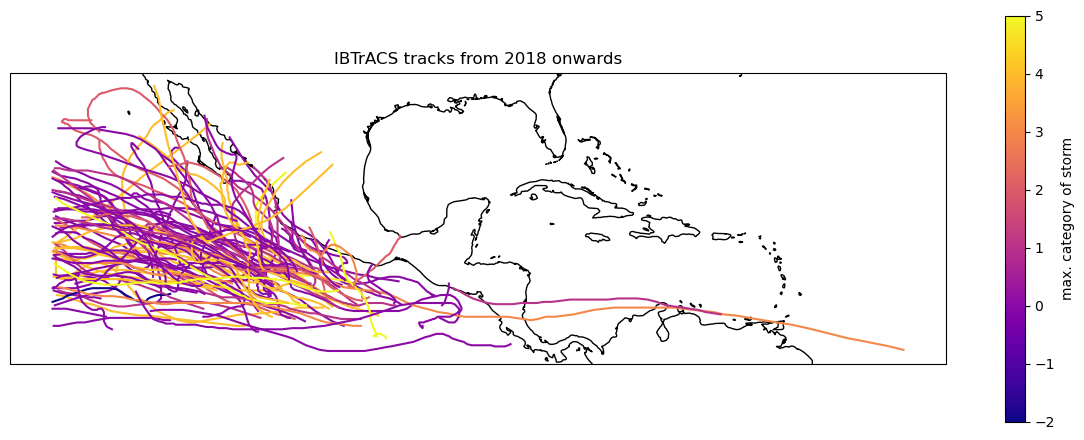

In [198]:
# Plot tracks on map
fig, ax = plt.subplots(figsize=(12, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
grouped = df_ep_filtered.groupby('SID')

# plot every track with colour for category
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=-2, vmax=5)
for i, (name, group) in enumerate(grouped):
    max_cat = group['USA_SSHS'].max()
    ax.plot(group['LON'], group['LAT'], transform=ccrs.PlateCarree(), label=name, color=cmap(norm(max_cat)))

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with colorbar
plt.colorbar(sm, ax=ax, label='max. category of storm')
plt.title('IBTrACS tracks from 2018 onwards')

plt.tight_layout()

In [199]:
# merge into one dataframe
df_all = pd.concat([df_na_filtered, df_ep_filtered], ignore_index=True)
df_all.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,2018146N19273,2018,25,NaN,GM,ALBERTO,2018-05-28 00:00:00,TS,28.2,-85.8,...,,,,12,70,,,70,7,315
1,2018146N19273,2018,25,NaN,GM,ALBERTO,2018-05-28 03:00:00,TS,28.4,-86.0,...,,,,,,,,,4,335
2,2018146N19273,2018,25,NaN,GM,ALBERTO,2018-05-28 06:00:00,TS,28.6,-86.0,...,,,,,,,,,4,0
3,2018146N19273,2018,25,NaN,GM,ALBERTO,2018-05-28 09:00:00,TS,28.8,-86.0,...,,,,,,,,,5,10
4,2018146N19273,2018,25,NaN,GM,ALBERTO,2018-05-28 12:00:00,TS,29.1,-85.9,...,,,,12,75,75,45,75,6,10


In [200]:
df_all.to_csv('goes_ibtracs.NA-EP.list.v04r01.csv', index=False)

In [202]:
# convert ISO_TIME to datetime
df_all['ISO_TIME'] = pd.to_datetime(df_all['ISO_TIME'])

In [203]:
# find total number of days covered by all storms
total_days = df_all.groupby('SID').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1).sum()

print(f"Total number of days covered by all storms: {total_days}")
print(f"Number of unique storms: {len(df_all.SID.unique())}")
print(f"Average days per storm: {total_days / len(df_all.SID.unique()):.1f}")

Total number of days covered by all storms: 1482
Number of unique storms: 237
Average days per storm: 6.3


/tmp/ipykernel_1243023/549307399.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_days = df_all.groupby('SID').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1).sum()


### Sample sub-set of storms

In [ ]:
# # Random sub-sampling
# # sample a subset of storms
# names = ['IAN']

# sampled_storms = df_all.SID.unique()
# sampled_storms = np.random.choice(sampled_storms, size=9, replace=False)
# sampled_storms = np.append(sampled_storms, df_all[df_all.NAME.isin(names)].SID.unique())
# df_sampled = df_all[df_all.SID.isin(sampled_storms)]

In [229]:
# Sample based on intensity
df_all['USA_SSHS'] = df_all['USA_SSHS'].astype(int)
max_intensity = df_all['USA_SSHS'].max()
print(f"Maximum intensity in the dataset: {max_intensity}") 

# pick 10 storms with intensity > 4  
intense_storms = df_all[df_all['USA_SSHS'] > 4].SID.unique()
print(f"Number of storms with intensity > 4: {len(intense_storms)}")

# sample storms based on intensity
sampled_storms = df_all[df_all.SID.isin(intense_storms)]

Maximum intensity in the dataset: 5
Number of storms with intensity > 4: 11


In [234]:
sampled_storms.NAME.unique()

array(['MICHAEL', 'DORIAN', 'LORENZO', 'IAN', 'LEE', 'BERYL', 'MILTON',
       'WILLA', 'JOVA', 'OTIS', 'KRISTY'], dtype=object)

In [232]:
# find total number of days covered by all storms
total_days = sampled_storms.groupby('SID').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1).sum()

print(f"Total number of days covered by all storms: {total_days}")
print(f"Number of unique storms: {len(sampled_storms.SID.unique())}")
print(f"Average days per storm: {total_days / len(sampled_storms.SID.unique()):.1f}")

Total number of days covered by all storms: 88
Number of unique storms: 11
Average days per storm: 8.0


/tmp/ipykernel_1243023/3827578878.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_days = sampled_storms.groupby('SID').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1).sum()


In [235]:
# safe dataframe to csv
sampled_storms.to_csv('goes_intense_ibtracs.NA-EP.list.v04r01.csv', index=False)

In [240]:
# save just the SIDs of the storms
sampled_storms.SID.unique().tofile('goes_intense_ibtracs.NA-EP.list.v04r01.SIDs.csv', sep='\n')

In [239]:
sampled_storms.groupby('NAME').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1)

/tmp/ipykernel_1243023/947105040.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_storms.groupby('NAME').apply(lambda x: (x['ISO_TIME'].max() - x['ISO_TIME'].min()).days + 1)


NAME
BERYL      11
DORIAN     15
IAN         9
JOVA        5
KRISTY      5
LEE        11
LORENZO     9
MICHAEL     6
MILTON      6
OTIS        5
WILLA       6
dtype: int64

### Load a GOES image

In [147]:
def get_goes_image(
    timestamp: str,)-> xr.Dataset:
    """
    Get the GOES image for a given timestamp.
    
    Args:
        timestamp (str): The timestamp in ISO format (e.g., '2023-10-01T12:00:00Z').
    
    Returns:
        xr.Dataset: The GOES dataset for the specified timestamp.
    """
    # Download the GOES data for the specified timestamp:
    goes_df = goes2go.goes_timerange(
        start = pd.to_datetime(timestamp), 
        end = pd.to_datetime(timestamp) + pd.Timedelta(minutes=10),
        satellite= 'noaa-goes16',
        download = False, 
        product = 'ABI-L2-MCMIP', 
        domain = 'F'
    )
      # Create filesystem object inside worker process to avoid fork-safety issues
    fs = fsspec.filesystem('s3', anon=True)
    fsspec_caching = {
        "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
        "block_size": 8 * 1024 * 1024 # size in bytes per block, adjust depends on the file size but the recommended size is in the MB}
    }
    ds = xr.open_dataset(fs.open(goes_df.file[0], **fsspec_caching), engine="h5netcdf")
    return ds

In [150]:
def get_abi_proj(dataset: xr.Dataset) -> Proj:
    """
    Return a pyproj projection from the information contained within an ABI file
    """
    return Proj(
        proj="geos",
        h=dataset.goes_imager_projection.perspective_point_height,
        lon_0=dataset.goes_imager_projection.longitude_of_projection_origin,
        lat_0=dataset.goes_imager_projection.latitude_of_projection_origin,
        sweep=dataset.goes_imager_projection.sweep_angle_axis,
    )


def get_abi_lat_lon(
    dataset: xr.Dataset, dtype: type = float
) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns latitude and longitude for each location in an ABI dataset
    """
    p = get_abi_proj(dataset)
    xx, yy = np.meshgrid(
        (
            dataset.x.data * dataset.goes_imager_projection.perspective_point_height
        ).astype(dtype),
        (
            dataset.y.data * dataset.goes_imager_projection.perspective_point_height
        ).astype(dtype),
    )
    lons, lats = p(xx, yy, inverse=True)
    lons[lons >= 1e30] = np.nan
    lats[lats >= 1e30] = np.nan
    return lats, lons

In [151]:
ds = get_goes_image('2023-10-01 12:00:00')

In [152]:
lats, lons = get_abi_lat_lon(ds)

In [156]:
np.nanmin(lats), np.nanmax(lats), np.nanmin(lons), np.nanmax(lons)

(np.float64(-81.14863073975214),
 np.float64(81.14659212288488),
 np.float64(-156.19352714824865),
 np.float64(6.197302874000297))

In [243]:
goes_df = goes2go.goes_timerange(
    start = '2018-10-01 00:00:00', 
    end = '2018-10-01 02:00:00', 
    satellite= 'noaa-goes16',
    download = False, 
    product = 'ABI-L2-MCMIP', 
    domain = 'F')


In [249]:
# select every other file
goes_df_2 = goes_df[::1]
goes_df_2.head()

,file,product_mode,satellite,start,end,creation,product,mode_bands,mode,band
0,noaa-goes16/ABI-L2-MCMIPF/2018/274/00/OR_ABI-L...,ABI-L2-MCMIPF-M4,G16,2018-10-01 00:00:22.200,2018-10-01 00:05:02.300,2018-10-01 00:05:11.400,ABI-L2-MCMIPF,M4,4,None
1,noaa-goes16/ABI-L2-MCMIPF/2018/274/00/OR_ABI-L...,ABI-L2-MCMIPF-M4,G16,2018-10-01 00:05:22.200,2018-10-01 00:10:02.300,2018-10-01 00:10:12.100,ABI-L2-MCMIPF,M4,4,None
2,noaa-goes16/ABI-L2-MCMIPF/2018/274/00/OR_ABI-L...,ABI-L2-MCMIPF-M4,G16,2018-10-01 00:10:22.200,2018-10-01 00:15:02.300,2018-10-01 00:15:13.700,ABI-L2-MCMIPF,M4,4,None
3,noaa-goes16/ABI-L2-MCMIPF/2018/274/00/OR_ABI-L...,ABI-L2-MCMIPF-M4,G16,2018-10-01 00:15:22.200,2018-10-01 00:20:02.300,2018-10-01 00:20:27.400,ABI-L2-MCMIPF,M4,4,None
4,noaa-goes16/ABI-L2-MCMIPF/2018/274/00/OR_ABI-L...,ABI-L2-MCMIPF-M4,G16,2018-10-01 00:20:22.200,2018-10-01 00:25:02.300,2018-10-01 00:25:11.400,ABI-L2-MCMIPF,M4,4,None
